this will use gabor only

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries, find_boundaries
from skimage.filters import gabor
from skimage.color import rgb2gray, label2rgb
from skimage.measure import regionprops
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
target_image_path = 'refrence-targets/target2.png'
reference_image_path = 'refrence-targets/reference2.png'

(-0.5, 503.5, 377.5, -0.5)

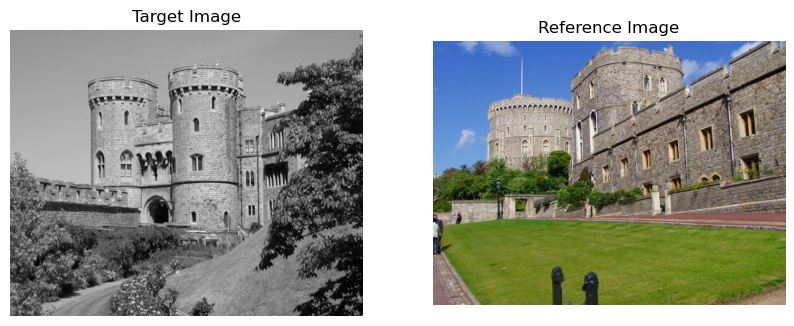

In [3]:
# Load grayscale target image and color reference image
target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

# Show the two images
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(target_image, cmap='gray')
plt.title('Target Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reference_image)
plt.title('Reference Image')
plt.axis('off')

In [4]:
# Convert to Lab color space
target_lab = cv2.cvtColor(cv2.cvtColor(target_image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2Lab)
reference_lab = cv2.cvtColor(reference_image, cv2.COLOR_BGR2Lab)

1-super pixels

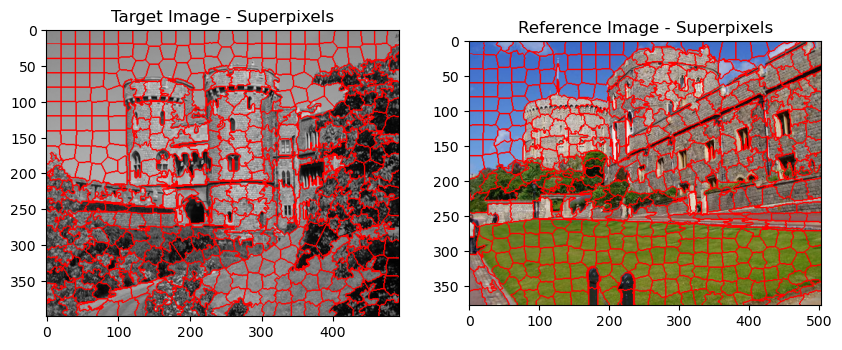

In [5]:
# Apply SLIC Superpixel Segmentation

#the input number of superpixels are chosen to keep an average superpixel size of around 40 pixels.

# height, width = target_lab.shape[:2]
# num_segments = (height * width) // 200
tar_height, tar_width, _ = target_lab.shape
tar_desired_superpixel_size = 20
tar_num_segments = (tar_height * tar_width) // (tar_desired_superpixel_size ** 2)

ref_height, ref_width, _ = reference_lab.shape
ref_desired_superpixel_size = tar_desired_superpixel_size
ref_num_segments = (ref_height * ref_width) // (ref_desired_superpixel_size ** 2)

target_superpixels = slic(target_lab, n_segments=tar_num_segments, compactness=10, sigma=1, start_label=0)
reference_superpixels = slic(reference_lab, n_segments=ref_num_segments, compactness=10, sigma=1, start_label=0)

# Display Superpixel Boundaries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mark_boundaries(target_image, target_superpixels, color=(1, 0, 0)))
ax[0].set_title("Target Image - Superpixels")
ax[1].imshow(mark_boundaries(reference_image, reference_superpixels, color=(1, 0, 0)))
ax[1].set_title("Reference Image - Superpixels")
plt.show()

In [6]:
print(f"Number of Superpixels in Target Image: {len(np.unique(target_superpixels))}")
print(f"Number of Superpixels in Reference Image: {len(np.unique(reference_superpixels))}")

Number of Superpixels in Target Image: 440
Number of Superpixels in Reference Image: 421


Merge small superpixels

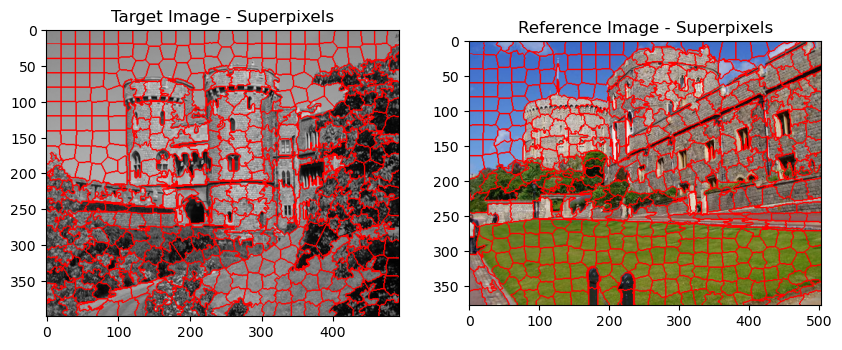

In [7]:
# Merge small segments based on a size threshold
min_size = 150
merged_segments = target_superpixels.copy()
for segment_id in set(target_superpixels.flatten()):
    if (target_superpixels == segment_id).sum() < min_size:
        merged_segments[target_superpixels == segment_id] = -1  # mark for merging

target_superpixels = merged_segments.copy()

merged_segments = reference_superpixels.copy()
for segment_id in set(reference_superpixels.flatten()):
    if (reference_superpixels == segment_id).sum() < min_size:
        merged_segments[reference_superpixels == segment_id] = -1  # mark for merging

reference_superpixels = merged_segments.copy()


# Display Superpixel Boundaries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mark_boundaries(target_image, target_superpixels, color=(1, 0, 0)))
ax[0].set_title("Target Image - Superpixels")
ax[1].imshow(mark_boundaries(reference_image, reference_superpixels, color=(1, 0, 0)))
ax[1].set_title("Reference Image - Superpixels")
plt.show()

another trial

In [27]:
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2lab, gray2rgb
import matplotlib.pyplot as plt

def get_neighbors(segments, segment_id):
    """Find neighboring segments for a given superpixel."""
    mask = segments == segment_id
    neighbors = set()
    
    # Check 8-connectivity (all adjacent pixels)
    for y, x in np.argwhere(mask):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if 0 <= ny < segments.shape[0] and 0 <= nx < segments.shape[1]:
                    neighbor = segments[ny, nx]
                    if neighbor != segment_id:
                        neighbors.add(neighbor)
    return neighbors

def merge_similar_regions(image, segments, color_threshold=5, max_iterations=2):
    """Merge similar superpixels with a strict max iteration limit."""
    if len(image.shape) == 2:  # Convert grayscale to RGB if needed
        image = gray2rgb(image)
    else:
        image = image.copy()

    lab_image = rgb2lab(image)
    merged_segments = segments.copy()

    for _ in range(max_iterations):  # Strict iteration limit
        segment_ids = set(merged_segments.flatten())
        new_segments = merged_segments.copy()
        merged = False

        for segment_id in segment_ids:
            neighbors = get_neighbors(merged_segments, segment_id)
            segment_mask = merged_segments == segment_id
            segment_color = lab_image[segment_mask].mean(axis=0)

            for neighbor in neighbors:
                if neighbor not in segment_ids:  # Skip already-merged neighbors
                    continue
                
                neighbor_mask = merged_segments == neighbor
                neighbor_color = lab_image[neighbor_mask].mean(axis=0)
                
                color_distance = np.linalg.norm(segment_color - neighbor_color)
                if color_distance < color_threshold:
                    new_segments[neighbor_mask] = segment_id
                    merged = True

        merged_segments = new_segments.copy()
        if not merged:
            break

    return merged_segments


# Display function
def display_superpixels(image, segments, title="Superpixels"):
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image, segments, color=(1, 0, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()


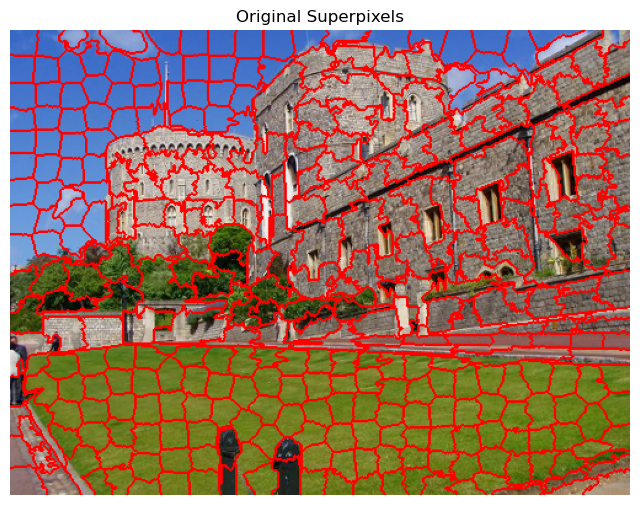

Number of Superpixels: 355


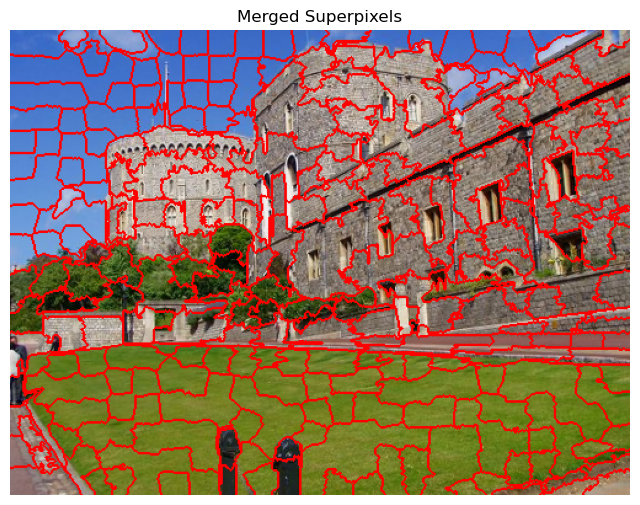

Number of Superpixels after merging: 200


In [28]:
ref_height, ref_width, _ = reference_lab.shape
ref_desired_superpixel_size = 20
ref_num_segments = (ref_height * ref_width) // (ref_desired_superpixel_size ** 2)

# Apply SLIC superpixels
segments = slic(reference_image, n_segments=ref_num_segments, compactness=10)

# Merge similar regions
merged_segments = merge_similar_regions(reference_image, segments)

# Display results
display_superpixels(reference_image, segments, title="Original Superpixels")
print(f"Number of Superpixels: {len(np.unique(segments))}")
display_superpixels(reference_image, merged_segments, title="Merged Superpixels")
print(f"Number of Superpixels after merging: {len(np.unique(merged_segments))}")

reference_superpixels = merged_segments.copy()


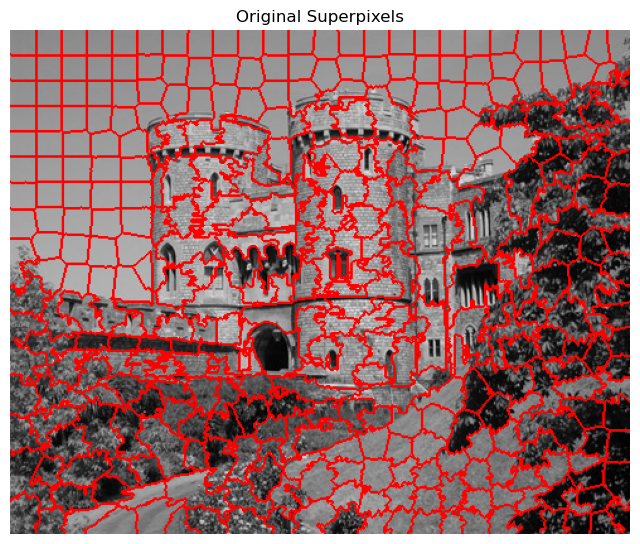

Number of Superpixels: 358


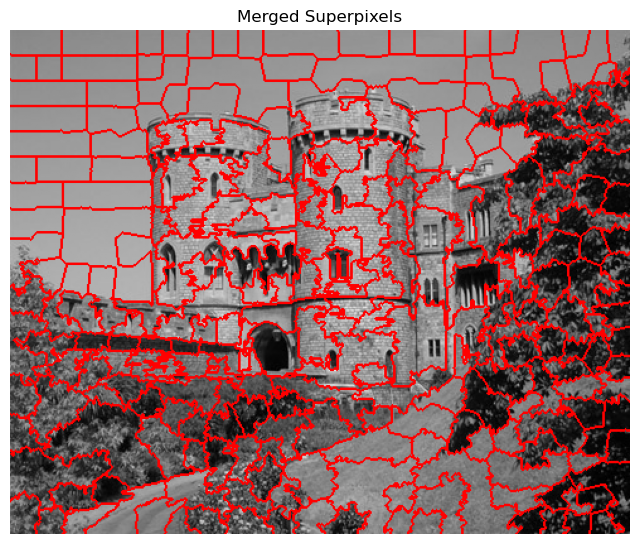

Number of Superpixels after merging: 183


In [29]:
tar_height, tar_width, _ = target_lab.shape
tar_desired_superpixel_size = ref_desired_superpixel_size
tar_num_segments = (tar_height * tar_width) // (tar_desired_superpixel_size ** 2)

# Apply SLIC superpixels
segments = slic(target_lab, n_segments=tar_num_segments, compactness=10)

# Merge similar regions
merged_segments = merge_similar_regions(target_image, segments)

# Display results
display_superpixels(target_image, segments, title="Original Superpixels")
print(f"Number of Superpixels: {len(np.unique(segments))}")
display_superpixels(target_image, merged_segments, title="Merged Superpixels")
print(f"Number of Superpixels after merging: {len(np.unique(merged_segments))}")

target_superpixels = merged_segments.copy()

In [30]:
# Print number of superpixels and neighbors for each image
print(f"Number of Superpixels (Target): {len(np.unique(target_superpixels))}")
print(f"Number of Superpixels (Reference): {len(np.unique(reference_superpixels))}")

Number of Superpixels (Target): 183
Number of Superpixels (Reference): 200


In [31]:
print(f"superpixels shape: {target_superpixels.shape}")
print(f"superpixels shape: {reference_superpixels.shape}")

superpixels shape: (400, 492)
superpixels shape: (378, 504)


In [32]:
print(f"superpixels first five: {target_superpixels[:5]}")

superpixels first five: [[58 58 58 ... 25 25 25]
 [58 58 58 ... 25 25 25]
 [58 58 58 ... 25 25 25]
 [58 58 58 ... 25 25 25]
 [58 58 58 ... 25 25 25]]


In [33]:
print(f"superpixels last five: {target_superpixels[-5:]}")

superpixels last five: [[337 337 337 ... 357 357 357]
 [337 337 337 ... 357 357 357]
 [337 337 337 ... 357 357 357]
 [337 337 337 ... 357 357 357]
 [337 337 337 ... 357 357 357]]


2-Feature extraction

In [34]:
import numpy as np
from skimage.segmentation import slic, mark_boundaries, find_boundaries
from skimage.color import rgb2lab
import matplotlib.pyplot as plt
import cv2
from skimage.filters import gabor

In [35]:
# Function to extract features for each pixel
def extract_pixel_features(image):
    height, width = image.shape[:2]
    features = np.zeros((height, width, 40))  # Adjusted size for Gabor features

    # Ensure the image has three channels (RGB)
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray_image = image
    else:
        # Compute intensity
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    features[:, :, 0] = gray_image

    # Compute Gabor features (magnitude)
    orientations = np.linspace(0, np.pi, 8, endpoint=False)
    scales = [np.exp(i) for i in range(5)]
    gabor_index = 0
    for scale in scales:
        for orientation in orientations:
            real, imag = gabor(gray_image, frequency=scale, theta=orientation)
            magnitude = np.sqrt(real**2 + imag**2)
            features[:, :, gabor_index] = magnitude
            gabor_index += 1

    return features

# Function to extract features for each superpixel
def extract_superpixel_features(image, superpixels):
    pixel_features = extract_pixel_features(image)
    features = {}
    unique_labels = np.unique(superpixels)

    for label in unique_labels:
        mask = (superpixels == label)
        superpixel_pixels = pixel_features[mask]

        # Compute mean feature vector for the superpixel
        mean_gabor = np.mean(superpixel_pixels[:, 1:], axis=0)  # Adjusted indices for Gabor features

        # Store features in a dictionary
        features[label] = {
            'gabor': mean_gabor
        }

    return features

In [36]:
# Extract features for target and reference images
target_features = extract_superpixel_features(target_image, target_superpixels)
reference_features = extract_superpixel_features(reference_image, reference_superpixels)


In [37]:
print(f"target_features: {target_features}")

target_features: {25: {'gabor': array([ 8.58729248, 11.0461853 ,  8.22245178, 10.85559082,  8.09005432,
       10.79966125,  8.63275452,  7.6703064 ,  7.6687439 ,  7.6734314 ,
        7.6687439 ,  7.6687439 ,  7.6687439 ,  7.6734314 ,  7.6687439 ,
        8.06729126,  8.06729126,  8.06729126,  8.06729126,  8.06729126,
        8.06729126,  8.06729126,  8.06729126,  9.89763184,  9.89763184,
        9.89763184,  9.89763184,  9.89763184,  9.89763184,  9.89763184,
        9.89763184, 10.61524048, 10.61524048, 10.61524048, 10.61524048,
       10.61524048, 10.61524048, 10.61524048, 10.61524048])}, 48: {'gabor': array([ 7.993743  , 11.38447719,  7.85568508,  8.99514191,  7.9067424 ,
       11.33207246,  8.07395092,  8.61838245,  8.61838245,  8.62154701,
        8.61554753,  8.6194373 ,  8.61554753,  8.62154701,  8.61838245,
        7.4346486 ,  7.4346486 ,  7.4346486 ,  7.4346486 ,  7.4346486 ,
        7.4346486 ,  7.4346486 ,  7.4346486 , 10.11124571, 10.11124571,
       10.11124571, 10.11124

In [38]:
# Function to compute Euclidean distance between two feature vectors
def euclidean_distance(f1, f2):
    return np.linalg.norm(f1 - f2)

# Function to perform cascade feature matching using only Gabor features
def cascade_feature_matching(target_features, reference_features):
    matched_superpixels = {}

    for t_label, t_features in target_features.items():
        # Compute distances for Gabor features
        gabor_distances = {r_label: euclidean_distance(t_features['gabor'], r_features['gabor'])
                           for r_label, r_features in reference_features.items()}

        # Find the best match
        best_match = min(gabor_distances, key=gabor_distances.get)
        matched_superpixels[t_label] = best_match

    return matched_superpixels


optimized

In [39]:
# Function to perform cascade feature matching using only Gabor features
def cascade_feature_matching(target_features, reference_features):
    matched_superpixels = {}

    for t_label, t_features in target_features.items():
        # Compute distances for Gabor features and find the best match
        best_match = min(reference_features.items(), key=lambda r: euclidean_distance(t_features['gabor'], r[1]['gabor']))[0]
        matched_superpixels[t_label] = best_match

    return matched_superpixels

In [40]:
# Perform cascade feature matching
matched_superpixels = cascade_feature_matching(target_features, reference_features)

In [41]:
# Print matched superpixels
print("Matched Superpixels:")
for t_label, r_label in matched_superpixels.items():
    print(f"Target Superpixel {t_label} matched with Reference Superpixel {r_label}")

print(f"Number of matched superpixels: {len(matched_superpixels)} out of {len(target_features)}")

Matched Superpixels:
Target Superpixel 25 matched with Reference Superpixel 143
Target Superpixel 48 matched with Reference Superpixel 143
Target Superpixel 49 matched with Reference Superpixel 143
Target Superpixel 50 matched with Reference Superpixel 211
Target Superpixel 51 matched with Reference Superpixel 143
Target Superpixel 52 matched with Reference Superpixel 157
Target Superpixel 53 matched with Reference Superpixel 143
Target Superpixel 56 matched with Reference Superpixel 157
Target Superpixel 58 matched with Reference Superpixel 126
Target Superpixel 60 matched with Reference Superpixel 143
Target Superpixel 61 matched with Reference Superpixel 157
Target Superpixel 63 matched with Reference Superpixel 157
Target Superpixel 64 matched with Reference Superpixel 3
Target Superpixel 65 matched with Reference Superpixel 143
Target Superpixel 66 matched with Reference Superpixel 3
Target Superpixel 68 matched with Reference Superpixel 3
Target Superpixel 69 matched with Referen

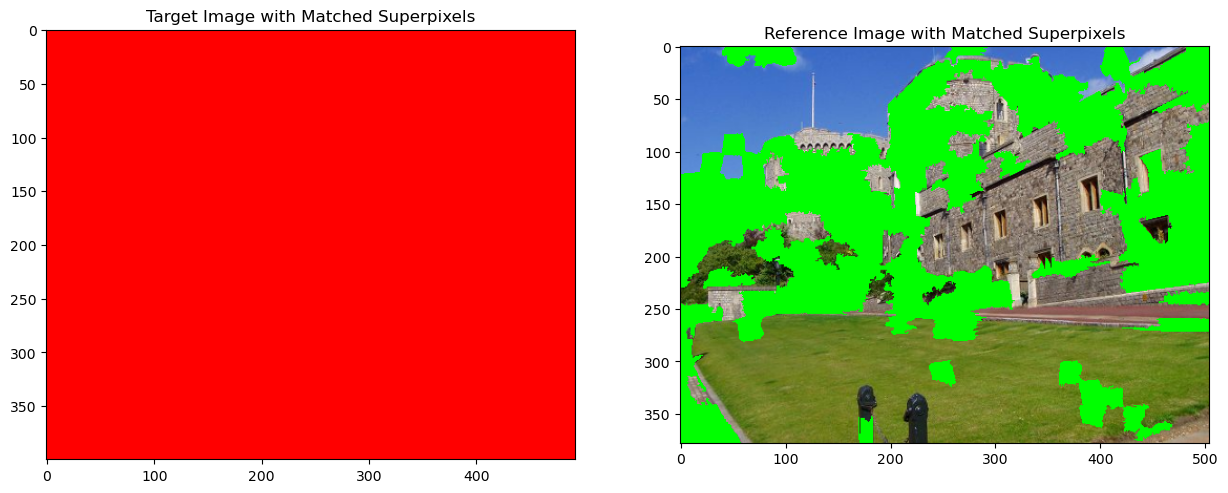

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to overlay dots on the matched superpixels
def overlay_dots(image, mask, color):
    overlay_image = image.copy()
    for c in range(3):  # Apply the color to each channel
        overlay_image[mask, c] = color[c]
    return overlay_image

# Create masks for the matched superpixels
target_matched_labels = list(matched_superpixels.keys())
reference_matched_labels = list(matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Overlay dots on the original images
def overlay_dots(image, mask, color):
    overlay_image = image.copy()
    if len(overlay_image.shape) == 2:  # Grayscale image
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_GRAY2RGB)
    for c in range(3):  # Apply the color to each channel
        overlay_image[mask, c] = color[c]
    return overlay_image

target_image_with_dots = overlay_dots(target_image, target_mask, [255, 0, 0])  # Red dots
reference_image_with_dots = overlay_dots(reference_image, reference_mask, [0, 255, 0])  # Green dots

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image_with_dots)
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image_with_dots)
ax[1].set_title("Reference Image with Matched Superpixels")
plt.show()

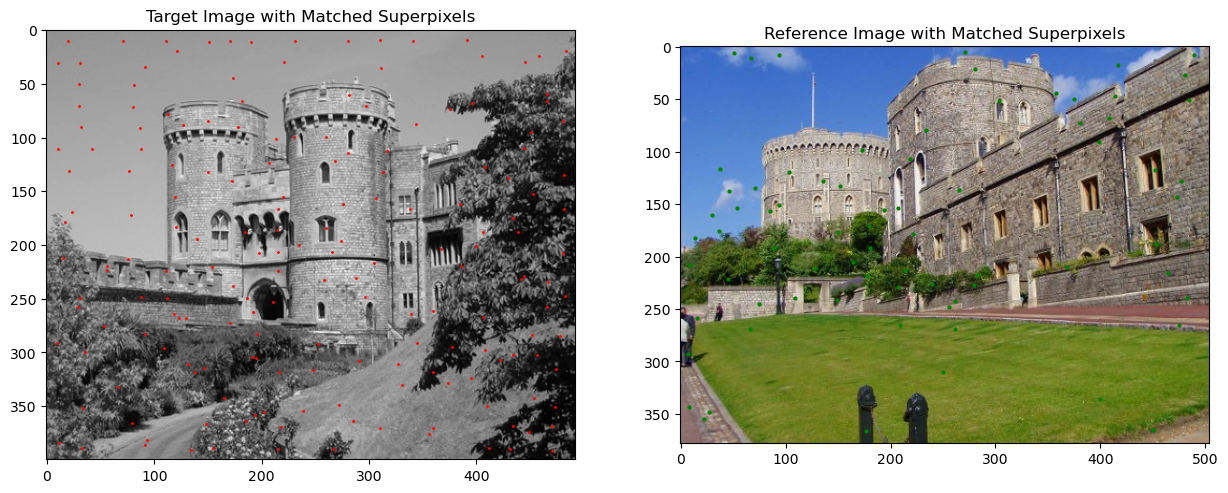

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to get the centroids of the matched superpixels
def get_superpixel_centroids(superpixels, matched_labels):
    centroids = []
    for region in regionprops(superpixels):
        if region.label in matched_labels:
            centroids.append(region.centroid)
    return centroids

# Create masks for the matched superpixels
target_matched_labels = list(matched_superpixels.keys())
reference_matched_labels = list(matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Get centroids of the matched superpixels
target_centroids = get_superpixel_centroids(target_superpixels, target_matched_labels)
reference_centroids = get_superpixel_centroids(reference_superpixels, reference_matched_labels)

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image, cmap='gray')
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image)
ax[1].set_title("Reference Image with Matched Superpixels")

# Plot small markers at the centroids of the matched superpixels
for centroid in target_centroids:
    ax[0].plot(centroid[1], centroid[0], 'ro', markersize=1)  # Red dots
for centroid in reference_centroids:
    ax[1].plot(centroid[1], centroid[0], 'go', markersize=2)  # Green dots

plt.show()

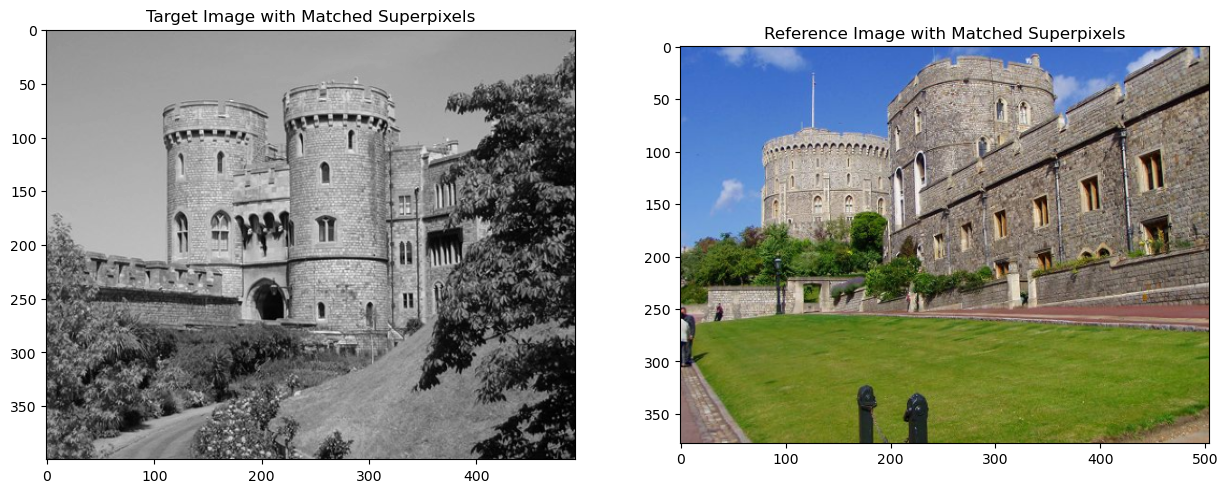

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to get the centroids of the matched superpixels
def get_superpixel_centroids(superpixels, matched_labels):
    centroids = []
    for region in regionprops(superpixels):
        if region.label in matched_labels:
            centroids.append(region.centroid)
    return centroids

# Function to create a list of numbers from start to end with step 1
def create_number_list(start, end):
    return list(range(start, end + 1))

# Specify superpixels of interest
# superpixels_of_interest = [4000 - 5001]  
superpixels_of_interest = create_number_list(4800, 4900)

# Filter matched superpixels to include only those of interest
filtered_matched_superpixels = {t_label: r_label for t_label, r_label in matched_superpixels.items() if t_label in superpixels_of_interest}

# Create masks for the matched superpixels
target_matched_labels = list(filtered_matched_superpixels.keys())
reference_matched_labels = list(filtered_matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Get centroids of the matched superpixels
target_centroids = get_superpixel_centroids(target_superpixels, target_matched_labels)
reference_centroids = get_superpixel_centroids(reference_superpixels, reference_matched_labels)

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image, cmap='gray')
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image)
ax[1].set_title("Reference Image with Matched Superpixels")

# Plot small markers at the centroids of the matched superpixels
#colors: r:red, g:green, b:blue, c:cyan, m:magenta, y:yellow, k:black, w:white
for centroid in target_centroids:
    ax[0].plot(centroid[1], centroid[0], 'ro', markersize=5)  # Red dots
for centroid in reference_centroids:
    ax[1].plot(centroid[1], centroid[0], 'co', markersize=5)  # Green dots

plt.show()

Initial colorization

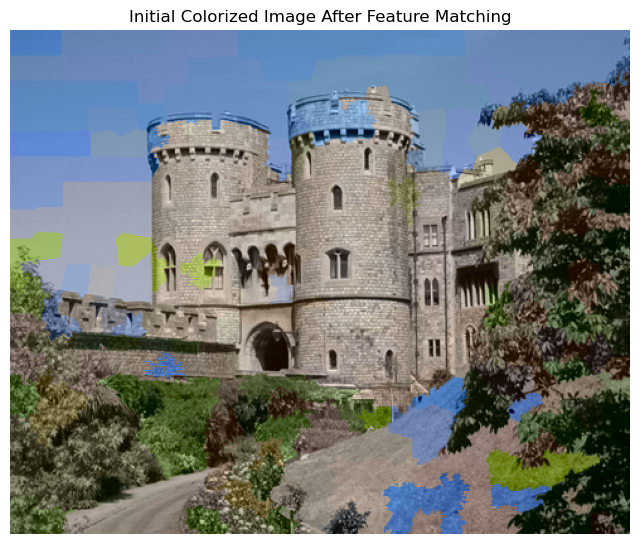

In [45]:
# Function to colorize the target image after feature matching
def colorize_after_matching(target_lab, target_superpixels, matches, reference_lab):
    colorized_image = target_lab.copy()
    for target_idx, ref_idx in matches.items():
        ref_mask = (reference_superpixels == ref_idx)
        ref_pixels = reference_lab[ref_mask, 1:3]  # Get 'a' and 'b' channels
        avg_color = np.mean(ref_pixels, axis=0) if len(ref_pixels) > 0 else [0, 0]

        mask = (target_superpixels == target_idx)
        colorized_image[mask, 1] = avg_color[0]  # 'a' channel
        colorized_image[mask, 2] = avg_color[1]  # 'b' channel

    return colorized_image

# Apply initial colorization after feature matching
initial_colorized_lab = colorize_after_matching(target_lab, target_superpixels, matched_superpixels, reference_lab)

# Visualize the initial colorized image
initial_colorized_rgb = cv2.cvtColor(initial_colorized_lab, cv2.COLOR_Lab2RGB)
initial_colorized_rgb = cv2.cvtColor(initial_colorized_rgb, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(initial_colorized_rgb)
plt.title("Initial Colorized Image After Feature Matching")
plt.axis('off')
plt.show()